In [1]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from PIL import Image

In [4]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformations with advanced augmentations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
from torchvision import datasets

# Load dataset with transform
dataset = datasets.ImageFolder(root='/kaggle/input/frame-data/frames', transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=15, shuffle=False, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=15, shuffle=False, num_workers=4)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm

# Load ViT model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
model = model.to(device)
model = nn.DataParallel(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Training loop with early stopping
num_epochs = 12
best_val_accuracy = 0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Save best model with early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_vit_model.pth')
        print(f"Best model saved with accuracy: {best_val_accuracy:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping due to no improvement.")
            break

    scheduler.step()

print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")


Epoch [1/12], Loss: 0.5536, Training Accuracy: 70.76%
Validation Accuracy: 83.07%
Best model saved with accuracy: 83.07%
Epoch [2/12], Loss: 0.3501, Training Accuracy: 83.44%
Validation Accuracy: 82.05%
Epoch [3/12], Loss: 0.2763, Training Accuracy: 86.54%
Validation Accuracy: 85.24%
Best model saved with accuracy: 85.24%
Epoch [4/12], Loss: 0.2455, Training Accuracy: 87.88%
Validation Accuracy: 87.70%
Best model saved with accuracy: 87.70%
Epoch [5/12], Loss: 0.2198, Training Accuracy: 88.06%
Validation Accuracy: 85.60%
Epoch [6/12], Loss: 0.1994, Training Accuracy: 88.66%
Validation Accuracy: 87.26%
Epoch [7/12], Loss: 0.1857, Training Accuracy: 89.27%
Validation Accuracy: 87.84%
Best model saved with accuracy: 87.84%
Epoch [8/12], Loss: 0.1795, Training Accuracy: 89.56%
Validation Accuracy: 87.63%
Epoch [9/12], Loss: 0.1814, Training Accuracy: 89.90%
Validation Accuracy: 88.13%
Best model saved with accuracy: 88.13%
Epoch [10/12], Loss: 0.1735, Training Accuracy: 90.37%
Validation A

In [8]:
print(train_loader.dataset.dataset.classes)

['manipulated', 'real']


In [9]:
import torch

In [10]:
import torch
import timm

# Load the ViT model architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=2)  # pretrained=False since we're loading custom weights
model = model.to(device)
model = torch.nn.DataParallel(model)

# Load the saved state dict
model.load_state_dict(torch.load('best_vit_model.pth'))
model.eval()

print("Model loaded successfully.")

# Example inference
sample_image = torch.randn(1, 3, 224, 224).to(device)  # Replace with actual input
output = model(sample_image)
_, predicted = torch.max(output, 1)
print(f"Predicted class: {predicted.item()}")


<ipython-input-10-e0b0182b7385>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vit_model.pth'))


Model loaded successfully.
Predicted class: 0


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize lists to store true and predicted labels
all_true_labels = []
all_predicted_labels = []

# Validation phase with detailed metrics
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Compute metrics
precision = precision_score(all_true_labels, all_predicted_labels, average='weighted')
recall = recall_score(all_true_labels, all_predicted_labels, average='weighted')
f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')
cm = confusion_matrix(all_true_labels, all_predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8830
Recall: 0.8828
F1 Score: 0.8828


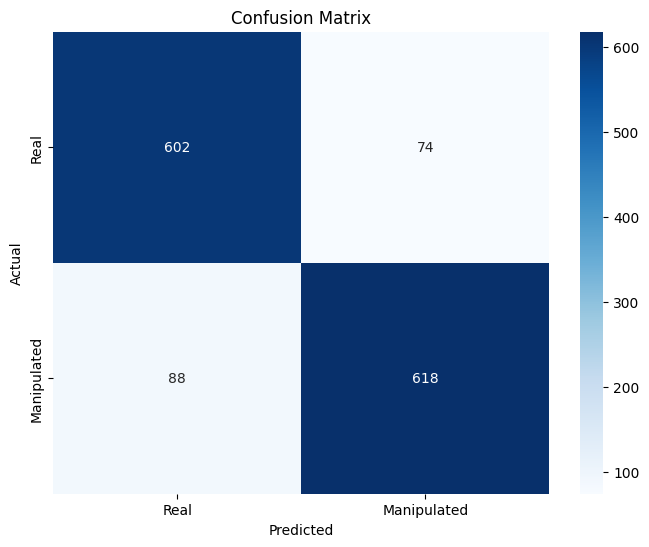

In [14]:
# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Manipulated'], yticklabels=['Real', 'Manipulated'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import cv2
import timm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the trained model
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=2)
# Load the trained model with weights_only=True for security
state_dict = torch.load('/kaggle/input/vit-model/best_vit_model.pth', map_location=device)
# Remove 'module.' prefix
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)

model.to(device)
model.eval()

# Function to process the video and classify each frame
def predict_video(video_path, model, transform, device):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    real_count = 0
    manipulated_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1

        # Convert frame to PIL Image and apply transformations
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

        # Make prediction
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
        
        if predicted.item() == 1:
            real_count += 1
        else:
            manipulated_count += 1

    cap.release()

    # Final decision based on majority vote across all frames
    if real_count > manipulated_count:
        print(f"Result: Real video ({real_count} real frames, {manipulated_count} manipulated frames)")
        return "Real"
    else:
        print(f"Result: Manipulated video ({real_count} real frames, {manipulated_count} manipulated frames)")
        return "Manipulated"

# Test the video
video_path = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_02__secret_conversation__YVGY8LOK.mp4"
result = predict_video(video_path, model, transform, device)


<ipython-input-22-67dd84b72873>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/input/vit-model/best_vit_model.pth', map_location=device)


Result: Manipulated video (0 real frames, 905 manipulated frames)


In [23]:
result

'Manipulated'